In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
pd.set_option('display.max_columns', None)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load in master categories from the CCSR grouping
CCSR_categories = pd.read_csv('/content/drive/MyDrive/Data/Output/master_categories.csv')

# drop ICD_CD_TRUNC and remove duplicates that from flags that may have crept in as a result of ICD_CD_TRUNC
CCSR_categories = CCSR_categories.drop(columns=['ICD_CD_TRUNC'])
CCSR_categories = CCSR_categories.drop_duplicates().reset_index(drop=True)
CCSR_categories

,BENE_ID,YR,CCSR_CATEGORY_DESCRIPTION,IP_FLAG,OP_FLAG,PR_FLAG
0,-10000010288010,2015,Aplastic anemia,N,N,Y
1,-10000010288010,2015,Obesity,N,N,Y
2,-10000010288010,2015,Spondylopathies/spondyloarthropathy (including...,N,N,Y
3,-10000010288010,2015,Neonatal cerebral disorders,N,N,Y
4,-10000010288010,2015,Prediabetes,N,N,Y
...,...,...,...,...,...,...
765886,-10000010254618,2023,Essential hypertension,N,Y,N
765887,-10000010254618,2023,Sinusitis,N,Y,N
765888,-10000010254618,2023,"Musculoskeletal pain, not low back pain",N,Y,N
765889,-10000010254618,2023,Male infertility,N,Y,N


In [ ]:
# prompt: order data frame by BENE_ID, YR, CCSR_CATEGORY_DESCRIPTION, descending values of IP_FLAG, descending values of OP_FLAG, and descending values of PR_FLAG.  If there are duplicates by BENE_ID, YR, CCSR_CATEGORY_DESCRIPTION, keep the first row.

# Sort the dataframe by the specified columns and keep the first row for duplicates.
CCSR_categories = CCSR_categories.sort_values(
    by=['BENE_ID', 'YR', 'CCSR_CATEGORY_DESCRIPTION', 'IP_FLAG', 'OP_FLAG', 'PR_FLAG'],
    ascending=[True, True, True, False, False, False]
).drop_duplicates(subset=['BENE_ID', 'YR', 'CCSR_CATEGORY_DESCRIPTION'], keep='first').reset_index(drop=True)

In [ ]:
# prompt: show distinct values of CCSR_CATEGORY_DESCRIPTION
# Show distinct values of CCSR_CATEGORY_DESCRIPTION
distinct_categories = CCSR_categories['CCSR_CATEGORY_DESCRIPTION'].unique()
print(distinct_categories)

['Aplastic anemia' 'Neonatal cerebral disorders' 'Obesity'
 'Personal history of other disease' 'Prediabetes'
 'Socioeconomic/psychosocial factors'
 'Spondylopathies/spondyloarthropathy (including infective)'
 'Epilepsy; convulsions' 'Lifestyle/life management factors'
 'Nervous system pain and pain syndromes'
 'Chronic rheumatic heart disease' 'Injury or poisoning and others'
 'External cause codes: other specified, classifiable and NEC; initial encounter'
 'Acute bronchitis' 'Sinusitis' 'Viral infection'
 'Abnormal findings without diagnosis'
 'Coronary atherosclerosis and other heart disease'
 'Essential hypertension'
 'Other specified and unspecified nutritional and metabolic disorders'
 'Other specified and unspecified perinatal conditions'
 'Any dental condition including traumatic injury'
 'Headache; including migraine' 'Other general signs and symptoms'
 'Other specified upper respiratory infections'
 'Acute and chronic tonsillitis' 'External cause codes: poisoning by drug'
 'N

In [ ]:
# Show categories containing 'diabetes'
diabetes = CCSR_categories[
    CCSR_categories['CCSR_CATEGORY_DESCRIPTION'].str.contains('diabetes', case=False, na=False)]['CCSR_CATEGORY_DESCRIPTION'].unique()
diabetes

array(['Prediabetes', 'Diabetes mellitus with complication',
       'Diabetes mellitus without complication'], dtype=object)

Definition of cohort: Those with category description of "Prediabetes" in 2017, with continuous enrollment from 2015-2025

In [ ]:
# prompt: filter CCSR_categories for YR=2017 and CCSR_CATEGORY_DESCRIPTION of 'Prediabetes'. Create dataframe prediab_2017 with distinct values of BENE_ID
prediab_2017 = CCSR_categories[(CCSR_categories.YR == 2017) & (CCSR_categories.CCSR_CATEGORY_DESCRIPTION == 'Prediabetes')][['BENE_ID']].drop_duplicates()
len(prediab_2017)

3318

In [ ]:
# get enrollment data, then filter for patients with BENE_ID in prediab file
enrollment = pd.read_csv('/content/drive/MyDrive/Data/Output/MemberYear.csv')
enrollment_prediab = enrollment[enrollment['BENE_ID'].isin(prediab_2017['BENE_ID'])]
enrollment_prediab

,BENE_ID,STATE_CODE,COUNTY_CD,ZIP_CD,BENE_BIRTH_DT,SEX_IDENT_CD,BENE_RACE_CD,ESRD_IND,BENE_DEATH_DT,BENE_ENROLLMT_REF_YR,BENE_BIRTH_YR,AGE_CALC,AGE_GRP
6,-10000010254671,1,1520,36786,1941-07-01,2,2,0,NaN,2015,1941,74,ADULT 65+
7,-10000010254676,1,1620,35476,1944-10-22,1,1,0,NaN,2015,1944,71,ADULT 65+
8,-10000010254682,1,1120,36545,1942-12-31,1,1,0,NaN,2015,1942,73,ADULT 65+
12,-10000010254721,1,1440,35758,1944-11-08,2,3,0,NaN,2015,1944,71,ADULT 65+
14,-10000010254731,1,1420,36785,1947-12-12,1,2,0,NaN,2015,1947,68,ADULT 65+
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86903,-10000010287983,5,5200,91108,1971-03-23,1,1,0,NaN,2025,1971,54,ADULT BELOW 65
86905,-10000010287992,5,5470,92126,1939-09-26,1,1,0,NaN,2025,1939,86,ADULT 65+
86907,-10000010287996,5,5400,92610,1967-09-17,2,5,Y,NaN,2025,1967,58,ADULT BELOW 65
86913,-10000010288007,5,5060,94598,1962-09-11,2,1,Y,NaN,2025,1962,63,ADULT BELOW 65


In [ ]:
enrollment_prediab.groupby('BENE_ENROLLMT_REF_YR')['BENE_ID'].count()

,BENE_ID
BENE_ENROLLMT_REF_YR,
2015,3020
2016,3173
2017,3318
2018,3318
2019,3318
2020,3318
2021,3318
2022,3318
2023,3318


Proceed to limit cohort to that of 2015 ($n=3020$) to allow for continuous enrollment (from 2015-2025)

In [ ]:
# prompt: create new dataframe of unique BENE_ID from enrollment_prediab where the mininum BENE_ENROLLMT_REF_YR=2015
#enrollment_prediab_2015 = enrollment_prediab[enrollment_prediab['BENE_ENROLLMT_REF_YR'] >= 2015]
unique_bene_ids_2015 = enrollment_prediab.groupby('BENE_ID')['BENE_ENROLLMT_REF_YR'].min().reset_index()
unique_bene_ids_2015 = unique_bene_ids_2015[unique_bene_ids_2015['BENE_ENROLLMT_REF_YR'] == 2015]
prediabetes_cohort = pd.DataFrame({'BENE_ID': unique_bene_ids_2015['BENE_ID']})
len(prediabetes_cohort)

NameError: name 'enrollment_prediab' is not defined

## **Patient journeys for chosen cohort**

In [ ]:
# get prediabetes cohort from CCSR categories via BENE_ID
CCSR_cohort = CCSR_categories[CCSR_categories['BENE_ID'].isin(prediabetes_cohort['BENE_ID'])].reset_index(drop=True)
CCSR_cohort.groupby('YR')['BENE_ID'].count()

,BENE_ID
YR,
2015,35659
2016,40478
2017,42755
2018,42169
2019,42681
2020,43969
2021,48144
2022,44342
2023,19085


Grab categories to be considered, including those that may be "possible" risk factors for diabetes or kidney disease. Create patient journeys (synthetically and intelligently).

In [ ]:
# categories to be considered, including "possible" risk factors
categories_needed = [
    "Prediabetes",
    "Diabetes mellitus with complication",
    "Diabetes mellitus without complication",
    # possible risk factors
    "Obesity",
    "Essential hypertension",
    "Hypertension with complications and secondary hypertension",
    "Coronary atherosclerosis and other heart disease",
    "Heart failure",
    "Socioeconomic/psychosocial factors",
    "Lifestyle/life management factors",
    "Alcohol-related disorders",
    "Depressive disorders",
    "Anxiety and fear-related disorders",
    "Sleep wake disorders",
    "Hepatitis"]

# Filter CCSR_cohort for CCSR_CATEGORY_DESCRIPTION in categories_needed
CCSR_cohort_filtered = CCSR_cohort[CCSR_cohort['CCSR_CATEGORY_DESCRIPTION'].isin(categories_needed)].reset_index(drop=True)

# generate random MONTH values for each row
np.random.seed(321) #random seed
CCSR_cohort_filtered['MONTH'] = np.random.randint(1, 13, size=len(CCSR_cohort_filtered))
CCSR_cohort_filtered

,BENE_ID,YR,CCSR_CATEGORY_DESCRIPTION,IP_FLAG,OP_FLAG,PR_FLAG,MONTH
0,-10000010288010,2015,Obesity,N,N,Y,5
1,-10000010288010,2015,Prediabetes,N,N,Y,11
2,-10000010288010,2015,Socioeconomic/psychosocial factors,N,N,Y,10
3,-10000010288010,2016,Lifestyle/life management factors,N,N,Y,9
4,-10000010288010,2016,Obesity,N,N,Y,2
...,...,...,...,...,...,...,...
140092,-10000010254671,2023,Coronary atherosclerosis and other heart disease,N,Y,N,1
140093,-10000010254671,2023,Lifestyle/life management factors,N,Y,N,11
140094,-10000010254671,2023,Obesity,N,Y,N,7
140095,-10000010254671,2023,Prediabetes,N,Y,N,12


In [ ]:
# prompt: show frequency counts of CCSR_CATEGORY_DESCRIPTION for values in diabetes_or_kidney_categories, grouping by YR
# group by YR and CCSR_CATEGORY_DESCRIPTION, then count the frequency for each combination.
frequency_counts = CCSR_cohort_filtered[CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION'].isin(diabetes)].groupby(['YR', 'CCSR_CATEGORY_DESCRIPTION'])['BENE_ID'].count().reset_index()
frequency_counts

,YR,CCSR_CATEGORY_DESCRIPTION,BENE_ID
0,2015,Diabetes mellitus with complication,957
1,2015,Diabetes mellitus without complication,472
2,2015,Prediabetes,2527
3,2016,Diabetes mellitus with complication,1044
4,2016,Diabetes mellitus without complication,526
5,2016,Prediabetes,2827
6,2017,Diabetes mellitus with complication,1104
7,2017,Diabetes mellitus without complication,557
8,2017,Prediabetes,3020
9,2018,Diabetes mellitus with complication,1119


In [ ]:
# prompt: sort the CCSR_cohort_filtered by BENE_ID and YR and MONTH
CCSR_cohort_filtered = CCSR_cohort_filtered.sort_values(['BENE_ID', 'YR','MONTH'])
CCSR_cohort_filtered

,BENE_ID,YR,CCSR_CATEGORY_DESCRIPTION,IP_FLAG,OP_FLAG,PR_FLAG,MONTH
0,-10000010288010,2015,Obesity,N,N,Y,5
2,-10000010288010,2015,Socioeconomic/psychosocial factors,N,N,Y,10
1,-10000010288010,2015,Prediabetes,N,N,Y,11
4,-10000010288010,2016,Obesity,N,N,Y,2
3,-10000010288010,2016,Lifestyle/life management factors,N,N,Y,9
...,...,...,...,...,...,...,...
140092,-10000010254671,2023,Coronary atherosclerosis and other heart disease,N,Y,N,1
140094,-10000010254671,2023,Obesity,N,Y,N,7
140096,-10000010254671,2023,Socioeconomic/psychosocial factors,N,Y,N,9
140093,-10000010254671,2023,Lifestyle/life management factors,N,Y,N,11


Ensure that once a patient is diagnosed with a more advanced stage of the diseases on the diabetes spectrum, they do not regress to an earlier stage in later years.

In [ ]:
# define disease progression order
disease_order = {
    'Prediabetes': 1,
    'Diabetes mellitus without complication': 2,
    'Diabetes mellitus with complication': 3,
    #'Chronic kidney disease': 4
    }

# preserve CCSR_CATEGORY_DESCRIPTION column (to keep track of values not in "disease_order")
CCSR_cohort_filtered['Orignal_CATEGORY_DESCRIPTION'] = CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION']

# map disease labels to progression levels
CCSR_cohort_filtered['DISEASE_STG'] = CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION'].map(disease_order)

# Ensure disease progression is non-decreasing over time for each BENE_ID
## ie., keep the highest stage encountered up until that point
## ...eg., [1, 2, 1, 3, 4] tranforms into [1, 2, 2, 3, 4]
def enforce_progression(patient_data):
    patient_data['DISEASE_STG'] = patient_data['DISEASE_STG'].cummax()
    return patient_data

CCSR_cohort_filtered = CCSR_cohort_filtered.groupby('BENE_ID').apply(enforce_progression)

# revert back to categorical labels after enforcing progression
reverse_disease_order = {v: k for k, v in disease_order.items()}
CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION'] = CCSR_cohort_filtered['DISEASE_STG'].map(reverse_disease_order)
CCSR_cohort_filtered = CCSR_cohort_filtered.reset_index(drop=True)

# restore original category labels for non-disease records
CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION'] = CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION'].fillna(CCSR_cohort_filtered['Orignal_CATEGORY_DESCRIPTION'])
CCSR_cohort_filtered

<ipython-input-113-514cddd948d1>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  CCSR_cohort_filtered = CCSR_cohort_filtered.groupby('BENE_ID').apply(enforce_progression)


,BENE_ID,YR,CCSR_CATEGORY_DESCRIPTION,IP_FLAG,OP_FLAG,PR_FLAG,MONTH,Orignal_CATEGORY_DESCRIPTION,DISEASE_STG
0,-10000010288010,2015,Obesity,N,N,Y,5,Obesity,NaN
1,-10000010288010,2015,Socioeconomic/psychosocial factors,N,N,Y,10,Socioeconomic/psychosocial factors,NaN
2,-10000010288010,2015,Prediabetes,N,N,Y,11,Prediabetes,1.0
3,-10000010288010,2016,Obesity,N,N,Y,2,Obesity,NaN
4,-10000010288010,2016,Lifestyle/life management factors,N,N,Y,9,Lifestyle/life management factors,NaN
...,...,...,...,...,...,...,...,...,...
140092,-10000010254671,2023,Coronary atherosclerosis and other heart disease,N,Y,N,1,Coronary atherosclerosis and other heart disease,NaN
140093,-10000010254671,2023,Obesity,N,Y,N,7,Obesity,NaN
140094,-10000010254671,2023,Socioeconomic/psychosocial factors,N,Y,N,9,Socioeconomic/psychosocial factors,NaN
140095,-10000010254671,2023,Lifestyle/life management factors,N,Y,N,11,Lifestyle/life management factors,NaN


In [ ]:
# identify patients with any regression in disease stage
def has_regression(patient_data):
    return (patient_data['DISEASE_STG'].diff() < 0).any()

# keep only patients with consistent progression, then drop disease stage
consistent_patients = ~CCSR_cohort_filtered.groupby('BENE_ID').apply(has_regression)
CCSR_cohort_filtered = CCSR_cohort_filtered[CCSR_cohort_filtered['BENE_ID'].isin(consistent_patients.index[consistent_patients])]
CCSR_cohort_filtered = CCSR_cohort_filtered.drop(columns=['DISEASE_STG','Orignal_CATEGORY_DESCRIPTION'])
CCSR_cohort_filtered

<ipython-input-114-ca2f650b44a4>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistent_patients = ~CCSR_cohort_filtered.groupby('BENE_ID').apply(has_regression)


,BENE_ID,YR,CCSR_CATEGORY_DESCRIPTION,IP_FLAG,OP_FLAG,PR_FLAG,MONTH
0,-10000010288010,2015,Obesity,N,N,Y,5
1,-10000010288010,2015,Socioeconomic/psychosocial factors,N,N,Y,10
2,-10000010288010,2015,Prediabetes,N,N,Y,11
3,-10000010288010,2016,Obesity,N,N,Y,2
4,-10000010288010,2016,Lifestyle/life management factors,N,N,Y,9
...,...,...,...,...,...,...,...
140092,-10000010254671,2023,Coronary atherosclerosis and other heart disease,N,Y,N,1
140093,-10000010254671,2023,Obesity,N,Y,N,7
140094,-10000010254671,2023,Socioeconomic/psychosocial factors,N,Y,N,9
140095,-10000010254671,2023,Lifestyle/life management factors,N,Y,N,11


In [ ]:
# prompt: within CCSR_cohort_filtered data frame, is there any BENE_ID whose CCSR_CATEGORY_DESCRIPTION is Prediabetes any year YR and at the time CCSR_CATEGORY_DESCRIPTION is either Diabetes mellitus without complication or Diabetes mellitus with complication in same YR? Is there any BENE_ID for which CCSR_CATEGORY_DESCRIPTION is Diabetes mellitus without complication in one YR and at the same time CCSR_CATEGORY_DESCRIPTION is Diabetes mellitus with complication in same YR? Any with

# Find BENE_IDs with Prediabetes and either Diabetes mellitus without complication or Diabetes mellitus with complication in the same year.
prediabetes_and_diabetes_same_year = CCSR_cohort_filtered[
    CCSR_cohort_filtered.groupby(['BENE_ID', 'YR'])['CCSR_CATEGORY_DESCRIPTION'].transform(lambda x: 'Prediabetes' in x.values and ('Diabetes mellitus without complication' in x.values or 'Diabetes mellitus with complication' in x.values))
]['BENE_ID'].unique()

print(f"BENE_IDs with Prediabetes and either type of Diabetes in the same year: {len(prediabetes_and_diabetes_same_year)}")

# Find BENE_IDs with Diabetes mellitus without complication and Diabetes mellitus with complication in the same year.
diabetes_without_and_with_complication_same_year = CCSR_cohort_filtered[
    CCSR_cohort_filtered.groupby(['BENE_ID', 'YR'])['CCSR_CATEGORY_DESCRIPTION'].transform(lambda x: 'Diabetes mellitus without complication' in x.values and 'Diabetes mellitus with complication' in x.values)
]['BENE_ID'].unique()

print(f"BENE_IDs with Diabetes mellitus without complication and Diabetes mellitus with complication in the same year: {len(diabetes_without_and_with_complication_same_year)}")

BENE_IDs with Prediabetes and either type of Diabetes in the same year: 564
BENE_IDs with Diabetes mellitus without complication and Diabetes mellitus with complication in the same year: 219


In [ ]:
# prompt: filter CCSR_CATEGORY_DESCRIPTION for values in "diabetes" vector; group by BENE_ID and count unique values of CCSR_CATEGORY_DESCRIPTION for each BENE_ID

# Group by BENE_ID and count unique CCSR_CATEGORY_DESCRIPTION values for each BENE_ID
bene_category_counts = CCSR_cohort_filtered[CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION'].isin(diabetes)].groupby('BENE_ID')['CCSR_CATEGORY_DESCRIPTION'].nunique().reset_index()
bene_category_counts = bene_category_counts.rename(columns={'CCSR_CATEGORY_DESCRIPTION': 'Unique_Diabetes_Categories_Count'})
bene_category_counts

,BENE_ID,Unique_Diabetes_Categories_Count
0,-10000010288010,1
1,-10000010288007,2
2,-10000010287992,1
3,-10000010287975,1
4,-10000010287949,2
...,...,...
3015,-10000010254731,1
3016,-10000010254721,2
3017,-10000010254682,1
3018,-10000010254676,1


In [ ]:
# Calculate frequency counts of Unique_Diabetes_Categories_Count
frequency_counts_diabetes = bene_category_counts['Unique_Diabetes_Categories_Count'].value_counts().reset_index()
frequency_counts_diabetes = frequency_counts_diabetes.rename(columns={'index': 'Unique_Diabetes_Categories_Count', 'Unique_Diabetes_Categories_Count': 'Frequency'})
frequency_counts_diabetes

,Frequency,count
0,1,2165
1,2,761
2,3,94


Patients have mutiple diagnoses/comorbidites of the same condition per year or across years. For each patient and diagnosis, needs to obtain the first time condition was diagnosed.

In [ ]:
# first get unique counts of diagnoses/comorbidites per patient
bene_category_counts = CCSR_cohort_filtered.groupby('BENE_ID')['CCSR_CATEGORY_DESCRIPTION'].nunique().reset_index()
bene_category_counts

,BENE_ID,CCSR_CATEGORY_DESCRIPTION
0,-10000010288010,4
1,-10000010288007,7
2,-10000010287992,8
3,-10000010287975,6
4,-10000010287949,8
...,...,...
3015,-10000010254731,5
3016,-10000010254721,9
3017,-10000010254682,6
3018,-10000010254676,5


In [ ]:
# prompt: group CCSR_cohort_filtered by BENE_ID and CCSR_CATEGORY_DESCRIPTION, then filter for the first row of each group

# Group by 'BENE_ID' and 'CCSR_CATEGORY_DESCRIPTION', then get the first row of each group.
CCSR_cohort_filtered = CCSR_cohort_filtered.groupby(['BENE_ID', 'CCSR_CATEGORY_DESCRIPTION']).first().reset_index()
CCSR_cohort_filtered = CCSR_cohort_filtered.sort_values(['BENE_ID', 'YR','MONTH'])
CCSR_cohort_filtered

,BENE_ID,CCSR_CATEGORY_DESCRIPTION,YR,IP_FLAG,OP_FLAG,PR_FLAG,MONTH
1,-10000010288010,Obesity,2015,N,N,Y,5
3,-10000010288010,Socioeconomic/psychosocial factors,2015,N,N,Y,10
2,-10000010288010,Prediabetes,2015,N,N,Y,11
0,-10000010288010,Lifestyle/life management factors,2016,N,N,Y,9
6,-10000010288007,Hypertension with complications and secondary ...,2015,N,Y,Y,2
...,...,...,...,...,...,...,...
18867,-10000010254671,Coronary atherosclerosis and other heart disease,2015,N,Y,Y,4
18869,-10000010254671,Obesity,2015,N,Y,Y,6
18870,-10000010254671,Prediabetes,2015,N,Y,Y,8
18868,-10000010254671,Lifestyle/life management factors,2015,N,Y,Y,11


In [ ]:
# group by 'YR' and 'CCSR_CATEGORY_DESCRIPTION' and count the occurrences
frequency_counts = CCSR_cohort_filtered.groupby(['YR', 'CCSR_CATEGORY_DESCRIPTION'])['BENE_ID'].count().reset_index(name='Count')
frequency_counts

,YR,CCSR_CATEGORY_DESCRIPTION,Count
0,2015,Alcohol-related disorders,153
1,2015,Anxiety and fear-related disorders,94
2,2015,Coronary atherosclerosis and other heart disease,1160
3,2015,Depressive disorders,52
4,2015,Diabetes mellitus with complication,957
...,...,...,...
104,2023,Diabetes mellitus without complication,1
105,2023,Essential hypertension,4
106,2023,Hypertension with complications and secondary ...,7
107,2023,Obesity,1


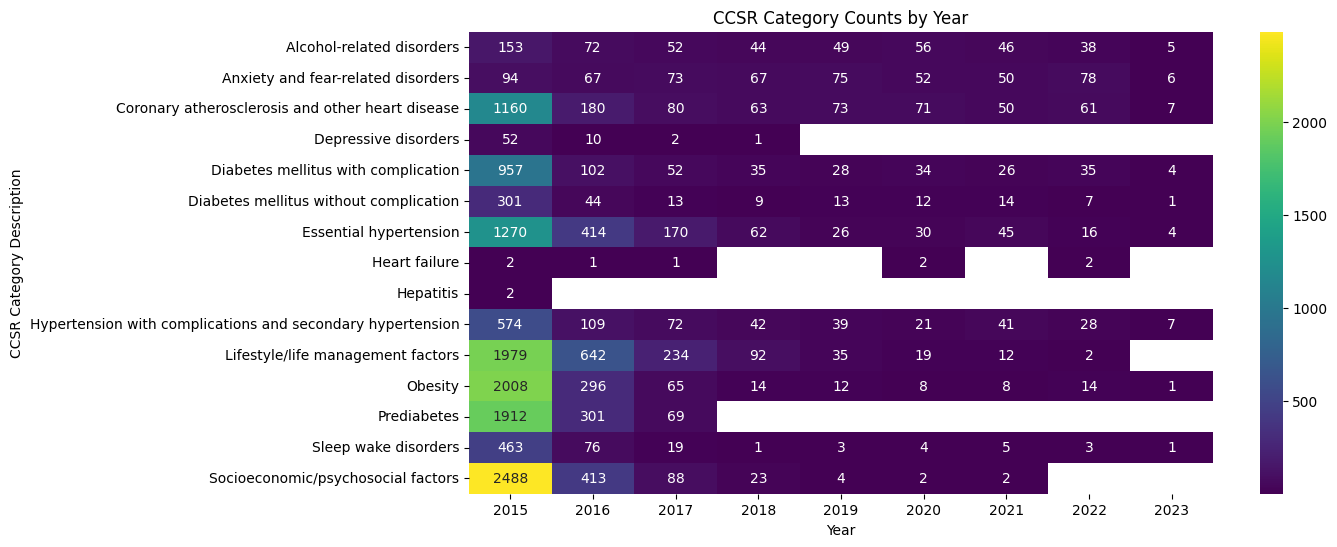

In [ ]:
# prompt: Using frequency_counts, create a heatmap of CCSR_DESCRIPTION_CATEGORY by COUNT and YR.  CCSR_DESCRIPTION_CATEGORY should be on the Y axis
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table for heatmap data
heatmap_data = frequency_counts.pivot(index='CCSR_CATEGORY_DESCRIPTION', columns='YR', values='Count')

# Create the heatmap
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='viridis')
plt.title('CCSR Category Counts by Year')
plt.xlabel('Year')
plt.ylabel('CCSR Category Description')
plt.show()

In [ ]:
CCSR_cohort_filtered.to_csv('/content/drive/MyDrive/Data/Output/diabetes_cohort.csv', index=False)